<a href="https://colab.research.google.com/github/sridevibonthu/SPRAG/blob/main/Inference/modelinference_finetuningwithmohler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [3]:
#Load the sprag dataset
data = pd.read_csv("mohler_dataset_edited.csv")
data.head(2)

,id,question,desired_answer,student_answer,score_me,score_other,score_avg
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0


In [4]:
data['bin_score'] = data.apply(lambda row : 1 if row.score_avg>=3 else 0, axis=1)

In [5]:
data = data.dropna()

In [6]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, random_state=42, test_size=0.3)

In [7]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)

  for idxA in range(len(sentence1)):
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])

		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))


	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [8]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['desired_answer'].values.tolist()
x_train_sA = train_data['student_answer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [9]:
#use test dataset as dev dataset
x_test_dA = test_data['desired_answer'].values.tolist()
x_test_sA = test_data['student_answer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = []
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples)

In [10]:
train_examples = []
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

In [11]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_pydsbert_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [12]:
from sentence_transformers import evaluation
import math

def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
    #model = SentenceTransformer(st_model)
    model = st_model
    #for evaluation
    train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
    test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')

    #configuring the training
    warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

    #print(warmup_steps)
    #train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=test_evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,
          #evaluation_steps=50,
          output_path=model_save_path,)
    print("Training done...")

In [13]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer(
"/content/drive/MyDrive/PhD/Application/PyDSVocab",
tokenizer_name_or_path="/content/drive/MyDrive/PhD/Application/PyDSVocab",
max_seq_length=128
)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
print("Done")

Done


In [15]:
st_model = 'PyDSBert'
num_epochs = 6
batch_size=32
model_save_path = "binary_sim_output_sprag_finetune/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)

test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Training done...



                     ********** PyDSBert **********

Training Accuracy

Test Accuracy


0.624633431085044

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
def make_predictions(model, pairs):
    # Initialize an empty list to hold the predicted scores
    scores = []

    # Loop through each pair of sentences
    for pair in pairs:
        # Get the embeddings for the pair of sentences
        sentence_embeddings = model.encode(pair.texts)

        # Calculate the similarity score between the two sentences
        #similarity_score = np.dot(sentence_embeddings[0], sentence_embeddings[1])
        #cosine_sim = cosine_similarity([sentence_embeddings[0]], [sentence_embeddings[1]])[0][0][0]
        cosine_sim = util.cos_sim(sentence_embeddings[0], sentence_embeddings[1])[0][0]
        # Append the similarity score to the list of scores
        scores.append((cosine_sim+1)/2)

    return scores

In [17]:
# Prepare sentence pairs (using your provided function)
from sentence_transformers import InputExample
# Select 5 random rows
#random_rows = data.sample(n=1000)

# Extract required columns
ref_answers = test_data['desired_answer'].tolist()
std_answers = test_data['student_answer'].tolist()
max_scores = test_labels.tolist()
#ref_answers = ['python is easy', 'keywords have predefined meaning', 'List, Set and Dictionary are mutable data structures in python']
#std_answers = ['python is simple', 'i do not know anything', 'Tha object structures which can be changeable are called mutable data structures']
pairs = []
for i in range(len(ref_answers)):
    #print(i)
    pairs.append(InputExample(texts=[ref_answers[i], std_answers[i]]))

In [18]:
# Make predictions using the trained model
from sentence_transformers import util
predicted_scores = make_predictions(model, pairs)

In [19]:
threshold = 0.6980
#actual = np.where(np.array(random_rows['avg_score'])>=3,1,0)
actual = test_labels
print(actual[:10])
preds_encoded = np.where(np.array(predicted_scores)>threshold,1,0)
print(preds_encoded[:10])

[1 1 1 1 1 0 1 1 1 1]
[1 1 1 1 1 0 1 1 1 1]


In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".2f", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()



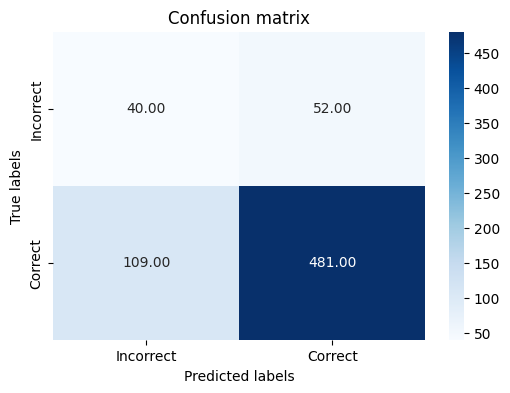

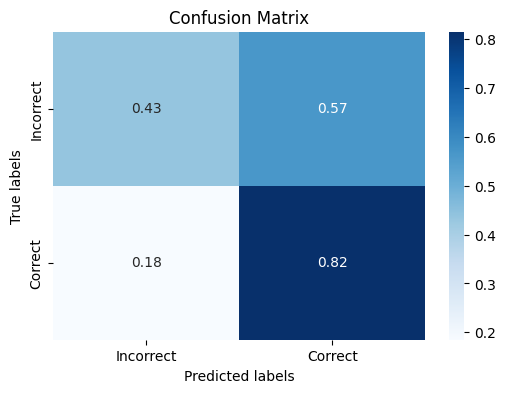

In [21]:
# Example usage:
# Define your actual and predicted binary values
y_true = [0, 1, 0, 1, 1, 0, 1, 0, 0, 1]
y_pred = [0, 1, 1, 1, 1, 0, 0, 0, 1, 1]

# Define class labels
classes = ['Incorrect', 'Correct']

# Plot non-normalized confusion matrix
plot_confusion_matrix(actual, preds_encoded, classes=classes, normalize=False, title='Confusion matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(actual, preds_encoded, classes=classes, normalize=True, title='Confusion Matrix')

In [22]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(actual, preds_encoded))

print(accuracy_score(actual, preds_encoded))

              precision    recall  f1-score   support

           0       0.27      0.43      0.33        92
           1       0.90      0.82      0.86       590

    accuracy                           0.76       682
   macro avg       0.59      0.63      0.59       682
weighted avg       0.82      0.76      0.79       682

0.7639296187683284


In [23]:
from sklearn.metrics import f1_score
f1 = f1_score(actual, preds_encoded)
print("F1 Score:", f1)

F1 Score: 0.8566340160284951


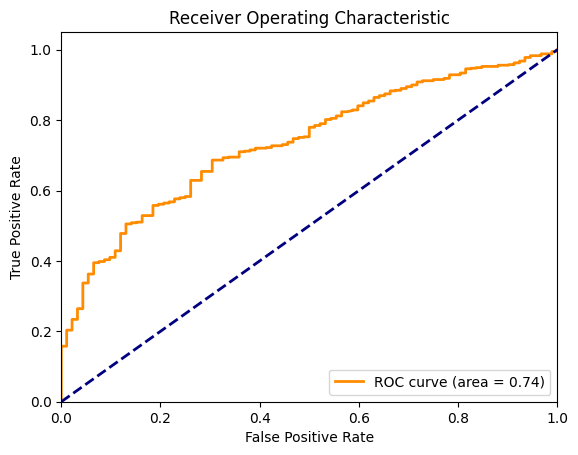

In [24]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(actual,predicted_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

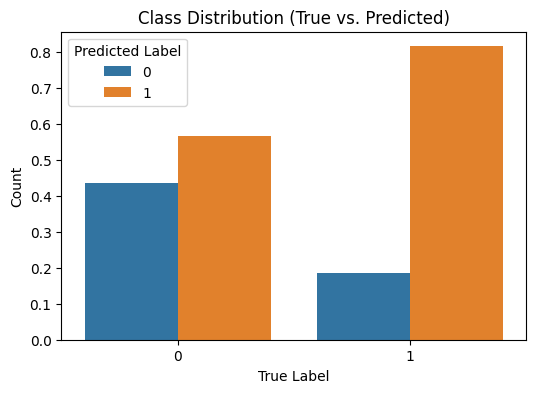

In [25]:
#Class Distribution plot
# Create a DataFrame with true and predicted labels
data = {
    'True Label': actual,
    'Predicted Label': preds_encoded
}
df = pd.DataFrame(data)
# Count occurrences of true and predicted labels
counts = df.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')

# Normalize the counts
counts['Normalized Count'] = counts.groupby('True Label')['Count'].transform(lambda x: x / x.sum())

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x='True Label', y='Normalized Count', hue='Predicted Label', data=counts)
plt.title('Class Distribution (True vs. Predicted)')
plt.xlabel('True Label')
plt.ylabel('Count')
plt.legend(title='Predicted Label')
plt.show()